In [1]:
# default_exp optimization.quantum_annealing

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Quantum Annealing

> Quantum Annealing Optimization API

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
#export

import networkx as nx
import warnings

# dwave imports
import dwave_networkx as dnx
from dwave.system import EmbeddingComposite, DWaveSampler
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler
from dimod import BinaryQuadraticModel


# local imports
from quixotic.optimization.base import QuantumOptimizer, DEFAULT_LOCAL_SIMULATOR


SUPPORTED_TASKS = {'maximum_clique': dnx.maximum_clique,
                  'minimum_vertex_cover': dnx.min_vertex_cover,
                   'minimum_weighted_vertex_cover' :dnx.min_weighted_vertex_cover,
                   'maximum_independent_set': dnx.maximum_independent_set,
                   'maximum_weighted_independent_set' : dnx.maximum_weighted_independent_set,
                   'maximum_cut' : dnx.maximum_cut,
                   'weighted_maximum_cut' : dnx.weighted_maximum_cut,
                   'structural_imbalance' : dnx.structural_imbalance,
                   'traveling_salesperson' : dnx.traveling_salesperson
                  }

BE_AWS = 'aws'
BE_DWAVE = 'dwave'
BE_LOCAL = 'local'
BACKENDS = [BE_AWS, BE_DWAVE, BE_LOCAL]

class QuantumAnnealer:

    """quantum-based combinatorial optimization with Amazon Braket
    
    
    Usage:

    ```python
    >>> qo = QuantumAnnealer(g, 
                            task='maximum_clique', 
                            device_arn='device_arn', # optional
                            s3_folder='s3_folder')   # optional
        qo.execute()
        results = qo.results()
    ```
    
    **Parameters:**
    
    * **graph** : a networkx Graph object
    * **task** : task as `str`.  Invoke `supported_tasks` static method to see options.
    * **bqm** : A `dimod.BinaryQuadraticModel`. If bqm supplied, then graph and task parameters are not needed.
    * **backend** : One of `{'local', 'aws', 'dwave'}` where:
                     - `local`: use a local solver (simulated annealing on your laptop)
                     - `aws`: use Amazon Braket (`device_arn` and `3_folder` args required)
                     - `dwave`: use D-Wave Leap System default solver as specified in `<home_directory/.config/dwave/dwave.conf

    * **device_arn** : Device ARN. Only required if not running locally.
    * **s3_folder** : S3 folder. Only required if not running locally.
    """
    def __init__(self, graph=None, task=None, bqm=None, backend=BE_LOCAL,
                 device_arn=None, s3_folder=None,
                 ):
        """
        constructor
        """
        # error checks
        if (graph is None or task is None) and bqm is None:
            raise ValueError('Either graph and task params must be supplied or bqm must be supplied.')
        if (graph is not None or task is not None) and bqm is not None:
            raise ValueError('bqm parameter is mutually exclusive with graph and task params.')
        if bqm is not None and not isinstance(bqm, BinaryQuadraticModel):
            raise ValueError('bqm must be an instance of dimod.BinaryQuadraticModel')
            
        if bqm is None and task not in SUPPORTED_TASKS: 
            raise ValueError(f'task {task} is not supported. ' +\
                             f'Supported tasks: {list(SUPPORTED_TASKS.keys())}')
        if bqm is None and not isinstance(graph, nx.Graph): 
            raise ValueError('g must be instance of networkx.Graph')
        if (device_arn is not None and s3_folder is None) or\
           (device_arn is None and s3_folder is not None):
            raise ValueError('If one of device_arn or s3_folder is supplied, then both must be supplied.')
        if backend != BE_AWS and device_arn is not None:
            warnings.warn('Switching backend to "aws" because device_arn and s3_folder were supplied.')
            backend = 'aws'
            
                        
        # input vars
        self.g = graph
        self.task = task
        self.bqm = bqm
        self.backend = backend
        self.device_arn = device_arn
        self.s3_folder = s3_folder


        # computed vars
        self._last_result = None
        self._exec_called = False

    @staticmethod
    def supported_tasks():
        """
        Prints supported tasks (valid values for the `task` parameter).
        """
        for task in SUPPORTED_TASKS:
            print(task)

    def is_local(self):
        return self.backend == BE_LOCAL
    
    def execute(self, verbose=1, **kwargs):
        """
        Approximate a solution to given task.
        Simulated Annealing is used when `QuantumAnnealer.local=True`.
        Quantum Annealing is used when `QuantumAnnealer.local=False`.
        """
        
        # setup sampler
        if self.backend == BE_LOCAL:
            if self.g is not None and self.g.number_of_nodes() < 18:
                from dimod.reference.samplers import ExactSolver
                sampler = ExactSolver()
            else:
                import neal
                sampler = neal.SimulatedAnnealingSampler()
            if verbose: print('Executing locally.')

        elif self.backend == BE_AWS:
            braket_sampler = BraketSampler(self.s3_folder, self.device_arn)
            sampler = EmbeddingComposite(braket_sampler)
            if verbose: print('Executing on Amazon Braket with results stored in %s/%s.' % (self.s3_folder))
        elif self.backend == BE_DWAVE:
            sampler = EmbeddingComposite(DWaveSampler())
            if verbose: print('Executing on D-Wave LEAP.')
        else:
            raise ValueError(f'Unknown backend value: {self.backend}')

            
        # generate approximation
        kwargs = {}
        if self.task is not None and 'weighted' in self.task: kwargs['weight'] = 'weight'
            
        if self.bqm is None:
            apx_fn = SUPPORTED_TASKS[self.task]
            if self.is_local():
                result = apx_fn(self.g, sampler, **kwargs)
            else:
                if self.backend == BE_AWS: kwargs['resultFormat'] = 'HISTOGRAM'
                result = apx_fn(self.g, sampler, **kwargs)      
        else:
            # use the sampler to find low energy states
            response = sampler.sample(self.bqm, **kwargs)

            # we want the lowest energy sample
            sample = next(iter(response))

            # nodes that are spin up or true are exactly the ones in S.
            result = [node for node in sample if sample[node] > 0]
            


        self._last_result = result
        self._exec_called = True
        return self

    
    def results(self, **kwargs):
        """
        Return approximated solution
        """
        if not self._exec_called: raise Exception('The execute method must be called first.')
        if 'return_probs' in kwargs and kwargs['return_probs']:
            warnings.warn('return_probs not currently supported in QuantumAnnealer, '+\
                          'so returning None for second return value.')
            return self._last_result, None
        else:
            return self._last_result
    

    def plot_samples(self, probs):
        """
        Plot sample for toy problems for testing purposes.
        """
        raise NotImplemented('QuantumAnnealer does not currently support plot_samples.')


In [5]:
show_doc(QuantumAnnealer.execute)

<h4 id="QuantumAnnealer.execute" class="doc_header"><code>QuantumAnnealer.execute</code><a href="__main__.py#L113" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.execute</code>(**`verbose`**=*`1`*, **\*\*`kwargs`**)

Approximate a solution to given task.
Simulated Annealing is used when [`QuantumAnnealer.local=True`](/quixotic/optimization.quantum_annealing.html#QuantumAnnealer.local=True).
Quantum Annealing is used when [`QuantumAnnealer.local=False`](/quixotic/optimization.quantum_annealing.html#QuantumAnnealer.local=False).

In [6]:
show_doc(QuantumAnnealer.results)

<h4 id="QuantumAnnealer.results" class="doc_header"><code>QuantumAnnealer.results</code><a href="__main__.py#L169" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.results</code>(**\*\*`kwargs`**)

Return approximated solution

In [7]:
show_doc(QuantumAnnealer.supported_tasks)

<h4 id="QuantumAnnealer.supported_tasks" class="doc_header"><code>QuantumAnnealer.supported_tasks</code><a href="__main__.py#L102" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantumAnnealer.supported_tasks</code>()

Prints supported tasks (valid values for the `task` parameter).

### Example: Minimum Vertex Cover with Quantum Annealing

The task is to find the nodes comprising the minimum vertex cover in a graph.  Let's construct a small star graph as input.

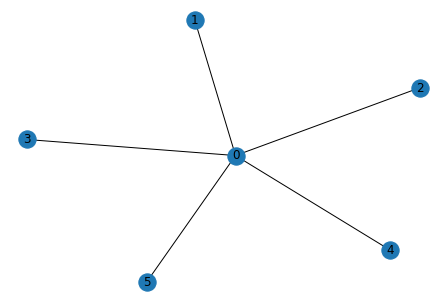

In [9]:
import networkx as nx

n = 6
g = nx.star_graph(n-1) 
seed = 1967
positions = nx.spring_layout(g, seed=seed)
nx.draw(g, with_labels=True, pos=positions)

In [10]:
qo = QuantumAnnealer(g, task='minimum_vertex_cover')

In [11]:
qo.execute()

Executing locally.


In [12]:
nodes = qo.results()

In [13]:
nodes

[0]

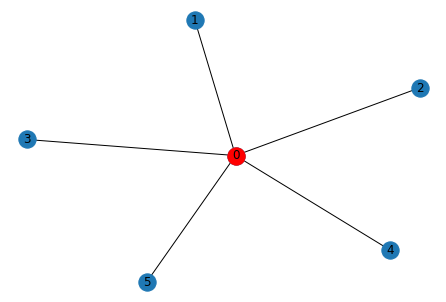

In [14]:
# plot solution as graph
sub = g.subgraph(nodes)
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

In [15]:
assert set(nodes) == set([0])

### Using a `BinaryQuadraticModel`

For more flexibility, you can formulate your problem as a `dimod.BinaryQuadraticModel` instance and supply that to `QuantumAnnealer` instead.  Here, we will solvethe same minimum vertex cover problem by formulating it as a binary quadratic model.  See [this reference](https://leeds-faculty.colorado.edu/glover/511%20-%20QUBO%20Tutorial%20-%20updated%20version%20-%20May%204,%202019.pdf) for more details on how to formulate problems as binary quadratic models.

Executing locally.


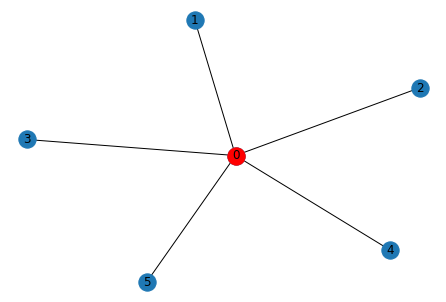

In [16]:
# formulate BQM optimization problem
cost = dict(g.nodes(data=None, default=1))
scale = max(cost.values())
Q = {(node, node): min(-cost[node] / scale, 0.0) for node in g}
Q.update({edge: 2.0 for edge in g.edges}) # use 2.0 as "tuning" LaGrange value for this problem
import dimod
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

# solve BQM
independent_set = QuantumAnnealer(bqm=bqm).execute().results()

# nodes NOT in the independent set comprise the minimum vertex cover
solution_nodes = [v for v in g if v not in independent_set]
assert set(solution_nodes) == set([0])

# plot solution as graph
sub = g.subgraph(solution_nodes)
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

In [17]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_optimization.base.ipynb.
Converted 02_optimization.quantum_annealing.ipynb.
Converted 03_optimization.qaoa.ipynb.
Converted 98_utils.ipynb.
Converted 99a_examples_quantum_annealing.ipynb.
Converted 99b_examples_qaoa.ipynb.
Converted index.ipynb.
